# Проблемы при работе с реальными данными

В реальных задачах вы столкнетесь с широким спектром трудностей, и одним из первых этапов будет подготовка данных. Уже на этом этапе есть ряд возможных проблем, например:

- **Нехватка данных** — у вас может быть мало данных. Более того, понять, какой объем данных необходим — тоже отдельная задача. Другая вариация похожей проблемы — это большой объем данных, но без разметки.

- **Некачественная разметка** —  даже в широко известных MNIST, CIFAR-10 и ImageNet есть [ошибки в разметке 🎮[demo]](https://labelerrors.com/). В вашем датасете они тоже будут. Важно понимать, что разметка может не являться бесспорным эталоном.

- **Шум в данных** — полезно подумать о потенциальной зашумленности данных. Например, когда люди заполняют таблицы, они могут допускать ошибки. Хорошо понимать, какого рода ошибки могут содержаться в ваших данных.

- **Несбалансированность датасета** — какие-то классы могут быть плохо представлены (**минорные классы**). Например, если в вашем датасете будет всего 10 фотографий одного класса и 10 000 другого, то модели будет очень заманчиво вообще не пытаться определять минорный класс (всего 0.1% ошибок).

- **Ковариантный сдвиг** — явление, когда признаки тренировочной и тестовой выборок **распределены по-разному**. Из-за этого мы можем получать плохие предсказания на тестовой выборке, когда модель просто не знает, что признаки могут находиться в другом распределении. [Подробнее 🎓[article]](https://www.researchgate.net/publication/339021786_Covariate_Shift_A_Review_and_Analysis_on_Classifiers)

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/covariate_shift.png" width="600"></center>

*Практический совет: для быстрого обнаружения ковариантного сдвига можно **обучить модель**, которая будет предсказывать, относится ли объект к **train** или **test** выборке. Если модель легко делит данные по такому принципу, то имеет смысл визуализировать значения признаков, по которым она это делает.*

- **Малое число источников данных** — проблема, родственная предыдущей. В вашем датасете могут быть данные только от одного прибора или одной модели прибора. Могут быть данные, снятые только одним специалистом, или в одной больнице, или только у взрослых. Это также может влиять на способность вашего алгоритма обобщать полученное решение и требует пристального внимания.

- **Грязные данные** — в данных могут быть полные/неполные дубликаты, пропуски, ошибки форматов, перемешанные столбцы и многое другое. Такие проблемы могут быть как естественной характеристикой (нет данных о каких-то объектах, отсюда пропуски), так и ошибкой при агрегации данных из разных источников. Важно подумать о проверках и тестах, чтобы быть уверенным в качестве.

Все это приводит к целому спектру сложностей, из которых самой типичной будет переобучение модели — какую бы простую модель вы не взяли, она все равно будет выучивать искажения вашего датасета.

## Дисбаланс классов

Важно обращать внимание на сбалансированность классов в наборе.
Предположим, у нас есть некоторый набор данных со следующими метками классов:

In [1]:
real_labels = [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]

В наборе 16 объектов относятся к классу 0, а 5 — к классу 1.

Мы обучили две модели. Первая всегда выдает 0:

In [2]:
model1_res = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Вторая сумела обнаружить некоторую закономерность в признаках:

In [3]:
model2_res = [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]

Рассчитаем Accuracy для этих моделей:

In [4]:
from sklearn.metrics import accuracy_score


print(f"Accuracy for model1: {accuracy_score(real_labels, model1_res):.4f}")
print(f"Accuracy for model2: {accuracy_score(real_labels, model2_res):.4f}")

Accuracy for model1: 0.7619
Accuracy for model2: 0.7619


Accuracy нельзя использовать, если данные не сбалансированы. Для несбалансированных данных необходимо использовать свои метрики и модели. Одной из таких метрик является balanced accuracy. При вычислении данной метрики считается полнота (recall) отдельно для каждого класса и вычисляется среднее значение:

In [5]:
from sklearn.metrics import balanced_accuracy_score

# Balanced accuracy for model1 = (16/16+0/5)/2 = 0.5
print(
    f"Balanced accuracy for model1: {balanced_accuracy_score(real_labels, model1_res):.3f}"
)
# Balanced accuracy for model2 = (12/16+4/5)/2 = 0.775
print(
    f"Balanced accuracy for model2: {balanced_accuracy_score(real_labels, model2_res):.3f}"
)

Balanced accuracy for model1: 0.500
Balanced accuracy for model2: 0.775


**Всегда проверяйте**, являются ли ваши данные сбалансированными и могут ли выбранные для оценки модели метрики работать с несбалансированными классами.

Прежде всего надо убедиться, что датасет сбалансирован:

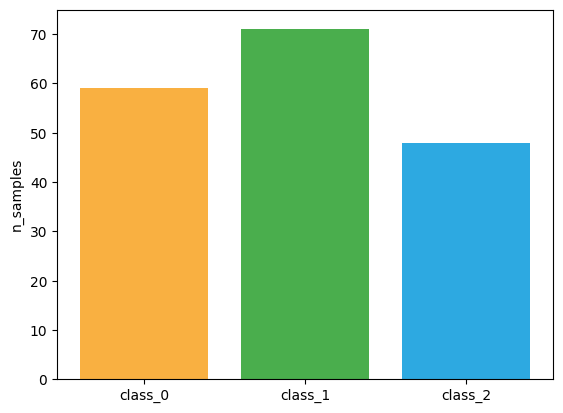

In [6]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine


def show_class_balance(y, classes, lim=75):
    _, counts = torch.unique(torch.tensor(y), return_counts=True)
    plt.bar(classes, counts, color=["#F9B041", "#4AAE4D", "#2DA9E1"])
    plt.ylabel("n_samples")
    plt.ylim([0, lim])
    plt.show()


wine = load_wine()
classes = wine.target_names

show_class_balance(wine.target, classes)

Разница в 10–20% будет незначительна, поэтому для наглядности мы искусственно создадим дисбаланс в датасете при помощи метода `make_imbalance` [🛠️[doc]](https://imbalanced-learn.org/stable/references/generated/imblearn.datasets.make_imbalance.html) из библиотеки [imbalanced-learn 🛠️[doc]](https://imbalanced-learn.org/stable/).

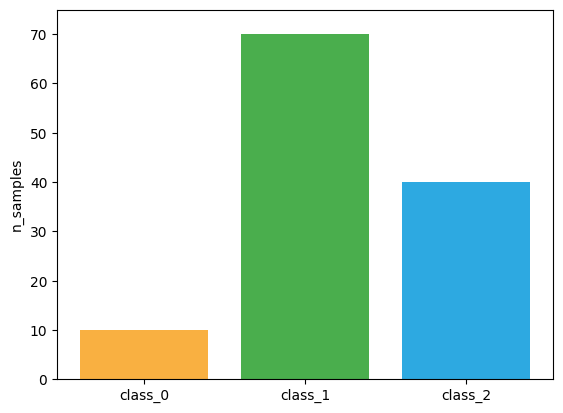

In [7]:
from imblearn.datasets import make_imbalance

x, y = make_imbalance(
    wine.data, wine.target, sampling_strategy={0: 10, 1: 70, 2: 40}, random_state=42
)
show_class_balance(y, classes)

### Изменение баланса класса сэмплированием

Если в данных нехватка именно конкретного класса, то можно бороться с этим при помощи разных способов сэмплирования.

Важно понимать, что в большинстве случаев данные, полученные таким способом, должны использоваться в качестве **обучающего набора**, но ни в коем случае не в качестве **валидации** или **теста**.


#### Дублирование примеров меньшего класса (oversampling)

Мы можем увеличить число объектов меньшего класса за счет дублирования.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/oversampling_scheme.png" width="600"></center>

<center><em>Дублирование примеров меньшего класса</em></center>



Такой oversampling может быть выполнен с помощью класса `RandomOverSampler` [🛠️[doc]](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html) из [imbalanced-learn🛠️[doc]](https://imbalanced-learn.org/stable/), как показано ниже:

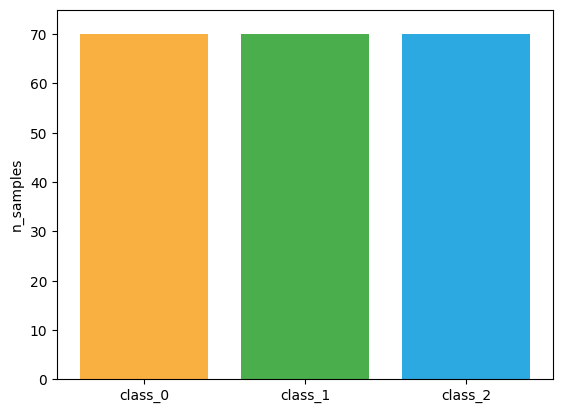

In [8]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
x_ros, y_ros = ros.fit_resample(x, y)

show_class_balance(y_ros, classes)

#### Уменьшение числа примеров большего класса (undersampling)

Аналогично, можно взять для обучения не всех представителей большего класса.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/undersampling_scheme.png" width="600"></center>

<center><em>Удаление примеров преобладающего класса</em></center>

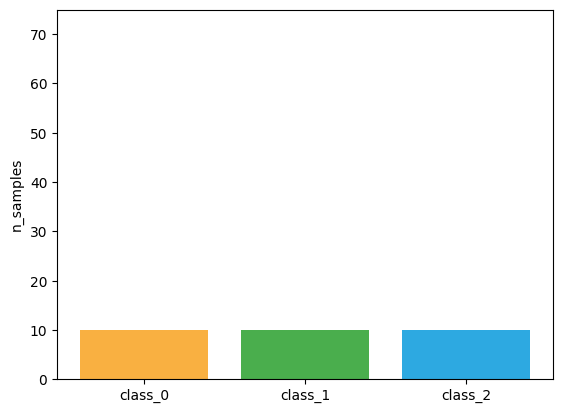

In [9]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
x_res, y_res = rus.fit_resample(x, y)

show_class_balance(y_res, classes)

Минус подхода: мы можем выбросить важные объекты большего класса, существенно улучшающих качество генерализации, и из-за этого качество модели существенно ухудшится.

Выбрасывать объекты большего класса  можно разными способами. Например, кластеризовать объекты большего класса и брать по заданному количеству объектов из каждого кластера.

#### Ансамбли + undersampling

Можно использовать ансамбли вместе с undersampling. В этом случае мы можем, к примеру, делать сэмплирование только большего класса, а объекты минорного класса оставлять как есть.

<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/ensembles_and_undersampling.png" width="700px"></center>

Рассмотрим пример обучения случайного леса из библиотеки imblearn, который используют такую технику для работы с дисбалансом и сравним с реализацией из sklearn.

Загрузим датасет с различными биомаркерами пациентов с меланомой (обезличенный, информации о пациентах нет) и переменной, содержащей 1, если пациент ответил на иммунотерапию (терапия помогла пациенту и произошло уменьшение размеров опухоли), и 0, если не ответил. Количество пациентов, отвечающих на терапию, сильно меньше пациентов, которым терапия не помогает, поэтому предсказание ответа пациента на терапию на основании биомаркеров — актуальная задача в онкологии. Решим ее на этом примере:

In [10]:
import pandas as pd
import numpy as np

cancer = pd.read_table(
    "https://ml.gan4x4.ru/msu/datasets/Cancer_dataset_2.tsv",
    index_col="sample_id",
)
cancer.reset_index(inplace=True)#.drop(columns=['sample_id'], inplace=True)
display(cancer.head())

# split the data on features (x) and dependant variable (y)
y_cancer = cancer["Response"]
x_cancer = cancer.drop(columns=["sample_id","Response"] , axis=1)

,sample_id,IgG1/IgA,IL21,CXCL9,CXCL10,CD8A,GZMB,KLRC2,KLRC3,KLRC4,GNLY,TGFB1,Response
0,SAM4b0175e8db6e,3.242746,0.001280,-0.002986,-0.036366,0.096658,0.063467,0.502058,-0.083862,0.053659,0.091930,61.934119,0
1,SAMd215b503f99a,2.139016,-0.000089,0.030495,0.243958,0.161128,0.565798,-0.203495,-0.026902,-0.035405,0.030125,103.265837,0
2,SAM7fb6987514a4,12.614972,0.008103,0.502043,0.530783,0.388455,0.528142,-0.156209,0.001147,-0.028690,0.260703,53.552817,0
3,SAMd636e3461955,6.365973,-0.000139,0.024035,0.115127,0.084455,0.200038,-0.387373,-0.057837,0.045938,0.073192,80.837318,0
4,SAMc0da5d48686d,2.764089,0.006107,0.015533,0.135470,0.067686,0.053499,-0.116040,0.063714,0.088201,0.082940,114.422926,0


Проверим дисбаланс:

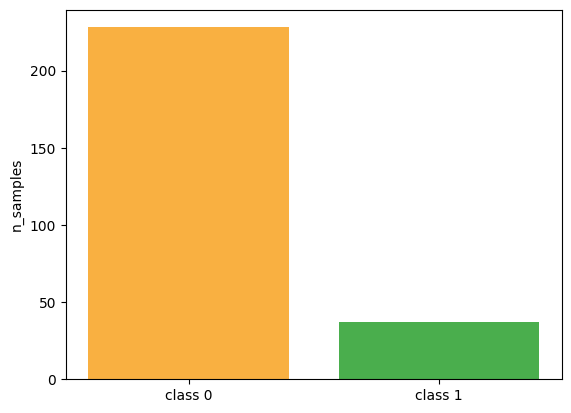

In [11]:
show_class_balance(y_cancer, ['class 0', 'class 1'], lim=None)

В данном случае имеет место несбалансированность классов в наборе данных: пациентов, ответивших на терапию, гораздо меньше.

Обучим три модели для сравнения

1. [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), библиотека sklearn
2. [`RandomForestClassifier` с балансировкой классов](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), библиотека sklearn — меняет стандартный вес каждого класса, равный 1, на долю класса во входных данных (см. `class_weight`).
3. [`BalancedRandomForestClassifier`](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html), библиотека imblearn — сэмплирует псевдовыборки таким образом, что в каждой псевдовыборке, которая подается на вход модели, баланс классов оказывается "выправлен".



Оценим эффективность подходов с помощью кросс-валидации, производя разбиение с учетом репрезентации классов и без него. В качестве метрики, отображающей эффективность модели, будем использовать значения `accuracy` и `balanced_accuracy`.


Объекты, принадлежащие разным классам, распределены неравномерно. Для адекватной работы `cross_validate` нужно перемешать данные. Для этого нужно использовать флаг `shuffle=True`, применяя `KFold` и `StratifiedKFold`.

In [12]:
import imblearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_validate,
)

cvs = {
    "cv_rand": KFold(n_splits=3, shuffle=True, random_state=42),
    "cv_strat": StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
}

models = {
    "rf_sklearn": RandomForestClassifier(
        n_estimators=500, max_depth=10, random_state=42
    ),
    "rf_sklearn_balanced": RandomForestClassifier(
        n_estimators=500, max_depth=10, class_weight="balanced", random_state=42
    ),
    "rf_imblearn": imblearn.ensemble.BalancedRandomForestClassifier(
        n_estimators=500, max_depth=10, random_state=42
    ),
}

for model_name, model in models.items():
    for name_cv, cv in cvs.items():
        scores = cross_validate(
            model, X=x_cancer, y=y_cancer, scoring=("accuracy", "balanced_accuracy"), cv=cv, n_jobs=-1
        )

        test_accuracy = scores["test_accuracy"].mean()
        test_balanced_accuracy = scores["test_balanced_accuracy"].mean()

        print(
            f"{model_name:<20} {name_cv:<8}: accuracy = {test_accuracy:.3f}, balanced_accuracy = {test_balanced_accuracy:.3f}"
        )

rf_sklearn           cv_rand : accuracy = 0.860, balanced_accuracy = 0.530
rf_sklearn           cv_strat: accuracy = 0.857, balanced_accuracy = 0.533
rf_sklearn_balanced  cv_rand : accuracy = 0.856, balanced_accuracy = 0.522
rf_sklearn_balanced  cv_strat: accuracy = 0.864, balanced_accuracy = 0.549
rf_imblearn          cv_rand : accuracy = 0.660, balanced_accuracy = 0.687
rf_imblearn          cv_strat: accuracy = 0.668, balanced_accuracy = 0.707


Видим, что случайный лес из imblearn со стратификацией справляется лучше всего (наибольшее значение метрики balanced accuracy)

### Генерация синтетических данных





**Synthetic Minority Over-sampling Technique (SMOTE)** позволяет генерировать синтетические данные за счет реальных объектов из минорного класса.

Алгоритм работает следующим образом:

1. Для случайной точки из минорного класса выбираем $k$ ближайших соседей из того же класса.
2. Для первого соседа проводим отрезок, соединяющий его и выбранную точку. На этом отрезке случайно выбираем точку.
3. Эта точка — новый **синтетический** объект минорного класса.
4. Повторяем процедуру для оставшихся соседей.


<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/generate_synthetic_data.png" width="700"></center>

Число соседей, как и число раз, которое мы запускаем описанную выше процедуру, можно регулировать.

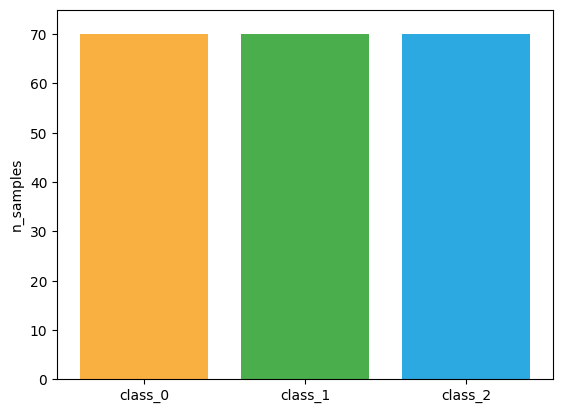

In [13]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
x_smote, y_smote = oversample.fit_resample(x, y)

show_class_balance(y_smote, classes)

Количество объектов каждого класса, которое должно получиться после генерации, можно задать явно:

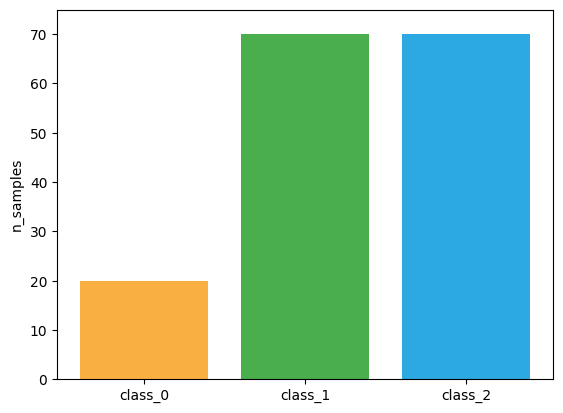

In [14]:
over = SMOTE(sampling_strategy={0: 20, 1: 70, 2: 70})
x_smote, y_smote = over.fit_resample(x, y)

show_class_balance(y_smote, classes)

[[blog] ✏️ SMOTE for Imbalanced Classification with Python](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) — подробнее про использование пакета.

# Обнаружение аномалий

В случае сильно несбалансированных наборов данных стоит задуматься, могут ли такие примеры рассматриваться как аномалия (выброс) или нет. Если такое событие и впрямь может считаться аномальным, мы можем использовать такие модели, как `OneClassSVM`, или методы кластеризации.

Эти методы требуют изменения взгляда на задачу: мы будем рассматривать аномалии как отдельный класс выбросов. Это может помочь нам найти новые способы разделения и классификации.

Пусть мы хотим отличать фрукты по каким-то признакам, скажем, по форме и цвету, и мы имеем выборку, где много яблок и груш. Задача обнаружения аномалий возникает, если мы предполагаем, что среди яблок и груш может вдруг возникнуть клубника и нам нужно отнести ее не к одному из известных классов, а выделить в отдельный, отличающийся класс.

<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/anomaly_fruits.png" width="800"></img></center>

Проблемой при работе с аномалиями является то, что аномальных значений может быть очень мало или вообще не быть. В таком случае алгоритм учит паттерны нормального поведения и реагирует на отличия от паттернов.

Разберем примеры обнаружения аномалий с помощью трех алгоритмов из библиотеки Scikit-Learn (там можно найти еще много различных алгоритмов).

Создадим датасет из двух кластеров и случайных значений.

In [15]:
import numpy as np

rng = np.random.RandomState(42)

# Train
x = 0.3 * rng.randn(100, 2)  # 100 2D points
x_train = np.r_[x + 2, x - 2]  # split into two clusters

# Test norlmal
x = 0.3 * rng.randn(20, 2)  # 20 2D points
x_test_normal = np.r_[x + 2, x - 2]  # split into two clusters

# Test outliers
x_test_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

Напишем функцию визуализации, которая будет изображать созданный датасет на рисунке слева, а результат поиска аномалий — на рисунке справа.

In [16]:
def plot_outliers(x_train, x_test_normal, x_test_outliers, model=None):
    fig, (plt_data, plt_model) = plt.subplots(1, 2, figsize=(12, 6))

    plt_data.set_title("Created Dataset (real labels)")
    plot_train = plt_data.scatter(
        x_train[:, 0], x_train[:, 1], c="white", s=40, edgecolor="k"
    )
    plot_test_normal = plt_data.scatter(
        x_test_normal[:, 0], x_test_normal[:, 1], c="green", s=40, edgecolor="k"
    )
    plot_test_outliers = plt_data.scatter(
        x_test_outliers[:, 0], x_test_outliers[:, 1], c="red", s=40, edgecolor="k"
    )

    plt_data.set_xlim((-5, 5))
    plt_data.set_ylim((-5, 5))

    plt_data.legend(
        [plot_train, plot_test_normal, plot_test_outliers],
        ["train", "test normal", "test outliers"],
        loc="lower right",
    )

    if model:
        plt_model.set_title("Model Results")
        # plot decision function
        xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
        Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt_model.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

        # plot prediction
        full_data = np.concatenate((x_train, x_test_normal, x_test_outliers), axis=0)
        predicted = model.predict(full_data)

        anom_index = np.where(predicted == -1)
        anom_values = full_data[anom_index]

        plot_all_data = plt_model.scatter(
            full_data[:, 0], full_data[:, 1], c="white", s=40, edgecolor="k"
        )

        plot_anom_data = plt_model.scatter(
            anom_values[:, 0], anom_values[:, 1], c="red", s=40, marker="x"
        )
        plt_model.legend(
            [plot_all_data, plot_anom_data],
            ["normal", "outliers"],
            loc="lower right",
        )
    plt.show()

Посмотрим, как работает на этих данных алгоритм [OneClassSVM 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html).

OneClassSVM (One-Class Support Vector Machine) работает следующим образом: алгоритм обучается на нормальных данных и создает гиперплоскость в многомерном пространстве, которая максимально отделяет большинство данных от начала координат. После обучения, новые наблюдения, которые оказываются далеко от этой гиперплоскости (внутри или снаружи), рассматриваются как аномалии.

Подробнее об алгоритме:

[[article] 🎓 Support Vector Method for Novelty Detection](https://proceedings.neurips.cc/paper/1999/file/8725fb777f25776ffa9076e44fcfd776-Paper.pdf)



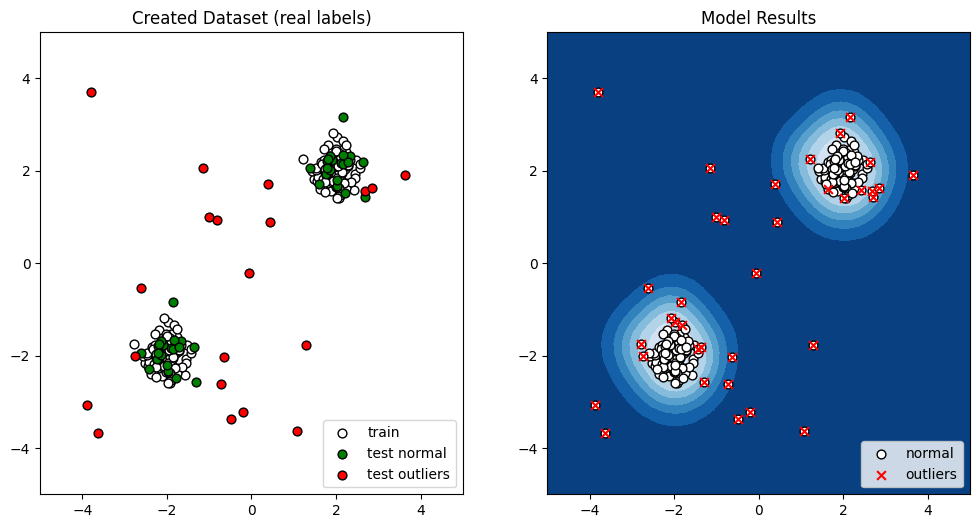

In [17]:
from sklearn.svm import OneClassSVM

gamma = 2.0  # Kernel coefficient
contamination = 0.05  # threshold

model = OneClassSVM(gamma=gamma, kernel="rbf", nu=contamination)
model.fit(x_train)

plot_outliers(x_train, x_test_normal, x_test_outliers, model)

Посмотрим, как на этих же данных работает алгоритм [Isolation Forest 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html).

Isolation Forest состоит из деревьев, которые «изолируют» (пытаются отделить от остальной выборки) наблюдения, случайным образом выбирая признак и случайное значение порога для этого признака (между максимальным и минимальным значениями признака). Если построить по такому принципу множество деревьев, то значения, которые чаще других отделяются раньше, будут аномалиями.

На практике часто используют более продвинутую версию [Extended Isolation Forest
🐾[git]](https://github.com/sahandha/eif).


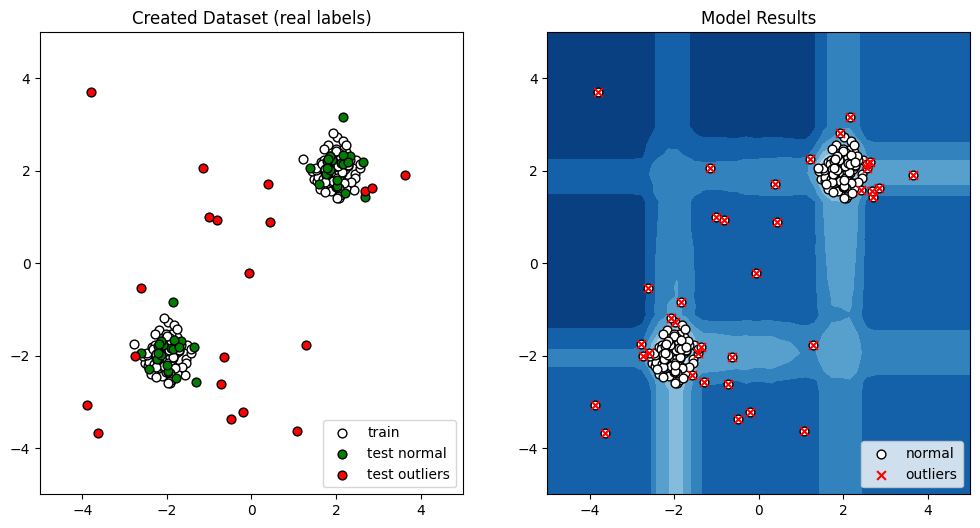

In [18]:
from sklearn.ensemble import IsolationForest

n_estimators = 200
contamination = 0.05  # threshold

model = IsolationForest(
    n_estimators=n_estimators, contamination=contamination, random_state=rng
)
model.fit(x_train)

plot_outliers(x_train, x_test_normal, x_test_outliers, model)

Последним алгоритмом, на который мы посмотрим, будет [Local Outlier Factor 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html).

В нем используется метод k-NN. Расстояние до ближайших соседей используется для оценки расположения точек. Если соседи далеко, то точка с большой вероятностью является аномалией.

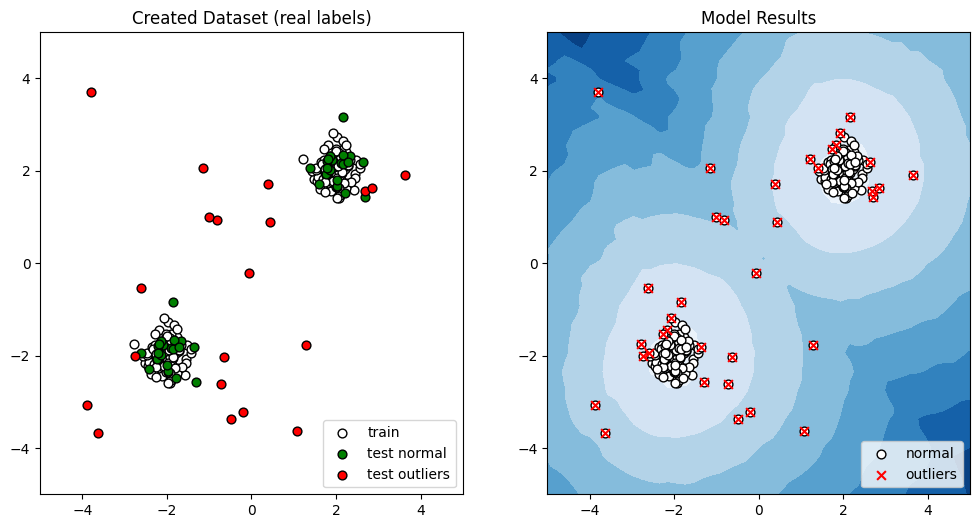

In [19]:
from sklearn.neighbors import LocalOutlierFactor

n_neighbors = 10
contamination = 0.05  # threshold

model = LocalOutlierFactor(
    n_neighbors=n_neighbors, novelty=True, contamination=contamination
)
model.fit(x_train)

plot_outliers(x_train, x_test_normal, x_test_outliers, model)

## Оценка качества в задаче обнаружения аномалий

Отдельное время стоит посвятить подбору порога для алгоритма.

Порог является граничным значением, выше которого данные считаются аномальными. Выбор порога — это компромиссное решение: слишком низкий порог может привести к ложным срабатываниям, тогда как слишком высокий порог может пропустить аномалии. Поэтому выбор порога напрямую связан с задачей и требованиям к детекции.

Построим матрицы ошибок (Confusion matrix) для разных порогов:


In [20]:
full_data = np.concatenate((x_train, x_test_normal, x_test_outliers), axis=0)
predicted = model.predict(full_data)

# change threshold to 0.005
model_2 = LocalOutlierFactor(n_neighbors=10, novelty=True, contamination=0.005)
model_2.fit(x_train)
predicted_2 = model_2.predict(full_data)

y_true = np.ones(full_data.shape[0])  # create true labels
y_true[-x_test_outliers.shape[0] :] = -1  # last 20 is anomaly

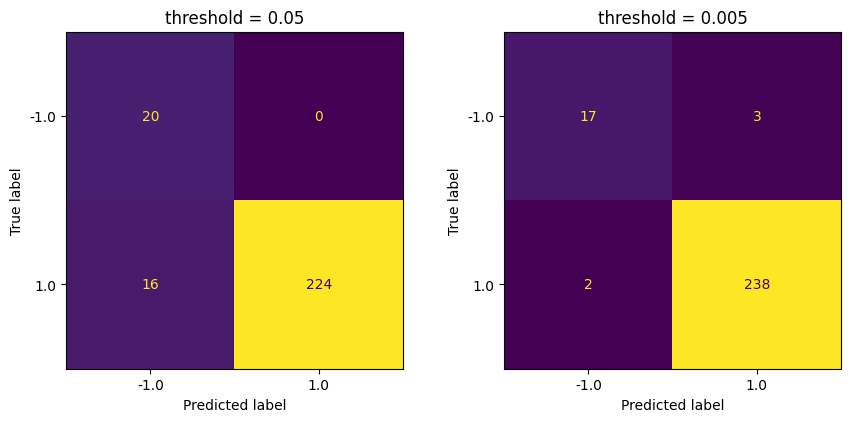

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ConfusionMatrixDisplay.from_predictions(y_true, predicted, ax=ax1, colorbar=False)
ConfusionMatrixDisplay.from_predictions(y_true, predicted_2, ax=ax2, colorbar=False)
ax1.set_title("threshold = 0.05")
ax2.set_title("threshold = 0.005")
plt.subplots_adjust(wspace=0.3)
plt.show()

Еще одна идея улучшения качества детекции аномалий — это агрегация результатов разных алгоритмов, т. е. создание ансамбля.